# Spatio-temporal mineral prospectivity mapping of Papua New Guinea

In [1]:
# setup the working environment
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from collections import deque
import contextily as cx
import cv2
import geopandas as gpd
import gplately
from ipywidgets import interact
import math
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
from ptt.subduction_convergence import subduction_convergence_over_time
from pulearn import BaggingPuClassifier
import pygplates
from scipy import ndimage
from scipy.interpolate import griddata
import scipy.spatial
import seaborn as sns
import shapefile
from shapely.geometry import LineString, Point
import statistics
from tqdm.notebook import tqdm

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

from lib import *

# load parameters
from parameters_muller2019_v27 import parameters

Cannot find header.dxf (GDAL_DATA is not defined)


# Convergence Kinematic Features

In [2]:
plate_motion_model = parameters['plate_motion_model']

# get start time, end time, and time step from parameters.py
time_period = parameters['time']
start_time = time_period['start']
end_time = time_period['end']
time_step = time_period['step']
time_steps = list(range(start_time, end_time+1, time_step))

conv_dir = parameters['convergence_data_dir']
conv_prefix = parameters['convergence_data_filename_prefix']
conv_ext = parameters['convergence_data_filename_ext']

# trench_points_features(
#     start_time,
#     end_time,
#     time_step,
#     conv_dir,
#     conv_prefix,
#     conv_ext,
#     plate_motion_model,
#     random_state=42
# )

In [3]:
if plate_motion_model == 'muller2016':
    rotation_files = parameters['rotation_file']
    topology_files = parameters['topology_file']
elif plate_motion_model == 'muller2019':
    rotation_files = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) in os.walk(parameters['rotation_dir']) for f in filenames]
    topology_files = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) in os.walk(parameters['topology_dir']) for f in filenames]

coastlines = parameters['coastlines_file']
static_polygons = parameters['static_polygons_file']
continents = parameters['coastlines_file']
cob = parameters['cob_file']

rotation_model = pygplates.RotationModel(rotation_files)

topology_features = pygplates.FeatureCollection()
for topology_file in topology_files:
    topology_features.add(pygplates.FeatureCollection(topology_file))

# use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

C:\Users\efar0517\Anaconda3\envs\png_jun23\Lib\site-packages\gplately\pygplates.py:192: ImportWarning: 
RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates
  _warnings.warn(msg, ImportWarning)


In [4]:
selected_features = parameters['selected_features']
selected_features_plot = selected_features.copy()
selected_features_plot.remove('distance_deg')

agegrid_dir = parameters['agegrid_dir']

# etopo_tif_img = gplately.download.get_raster('ETOPO1_tif')

extent_globe = [-180, 180, -90, 90]
# proj = ccrs.Mollweide(central_longitude=150)

@interact
def show_map(time=time_steps, feature=selected_features_plot):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    features_t = pd.read_csv(f'{conv_dir}/{conv_prefix}_{time}.00.{conv_ext}', index_col=False)

    # single colour bar
    # fig = plt.figure(figsize=(16, 12))
    # ax = plt.axes(projection=proj)
    
    # dual colour bars
    fig = plt.figure(figsize=(16, 12))
#     gs = GridSpec(2, 2, hspace=0.05, wspace=0.6, height_ratios=[0.96, 0.04])
    gs = GridSpec(2, 2, hspace=-0.4, wspace=0.4, height_ratios=[1, 0.02])
    ax = fig.add_subplot(gs[0, :], projection=ccrs.Mollweide(central_longitude=150))
    
    ax.set_global()

    # im = ax.imshow(agegrid.data, extent=extent_globe, origin='lower',cmap='Blues',transform=ccrs.PlateCarree(), alpha=0.5)
    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)
    # etopo_tif_img.imshow(alpha=0.2)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05, zorder=3)
    # gplot.plot_coastlines(ax, color='0.5')
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=10, spacingY=10, normalise=True, alpha=0.1, zorder=4)

    sc = ax.scatter(features_t['trench_lon'], features_t['trench_lat'], 50, marker='.',
                    c=features_t[feature], cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder=5)

    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.05, color='k', alpha=0.3, zorder=7)
    
    ax.gridlines(linestyle=':')
    
    # fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    fig.colorbar(sc, cax=cax2, orientation='horizontal', label=feature, extend='both')
    fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
        
#     ax.title.set_text(f'Subduction Zones {time} Ma')
    ax.set_title(f'Subduction Zones {time} Ma')
    
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [5]:
target_extent_file = parameters['target_extent_file']
target_extent_gdf = gpd.read_file(target_extent_file)
target_extent_bounds = target_extent_gdf.bounds
target_extent = [target_extent_bounds.loc[0]['minx'], target_extent_bounds.loc[0]['maxx'],
                 target_extent_bounds.loc[0]['miny'], target_extent_bounds.loc[0]['maxy']]

if target_extent[0] < -180:
    target_extent[0] = -180
if target_extent[1] > 180:
    target_extent[1] = 180
if target_extent[2] < -90:
    target_extent[2] = -90
if target_extent[3] > 90:
    target_extent[3] = 90

features_target_extent_files_lst = []

for time in time_steps:
    features_target_extent_files_lst.append(f'{conv_dir}/{conv_prefix}_target_extent_{time}.00.{conv_ext}')

for features_target_extent_file in tqdm(features_target_extent_files_lst):
    if not os.path.isfile(features_target_extent_file):
        time = features_target_extent_files_lst.index(features_target_extent_file)
        features_t = pd.read_csv(f'{conv_dir}/{conv_prefix}_{time}.00.{conv_ext}', index_col=False)
        features_target_extent_lst = []

        for i in range(features_t.shape[0]):
            x = features_t.iloc[i]['trench_lon']
            y = features_t.iloc[i]['trench_lat']
            p = Point((x, y))
            if p.within(target_extent_gdf.geometry[0]):
                features_target_extent_lst.append(features_t.iloc[i].values)

        features_target_extent = pd.DataFrame(np.row_stack(features_target_extent_lst), columns=features_t.columns)
        features_target_extent.to_csv(features_target_extent_file, index=False)

  0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
def set_ax(ax, extent, interval_x, interval_y, font_size=None, stock_img=True, order=None):
    if stock_img:
        ax.stock_img()

    ax.set_extent(extent)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--', 
                      xlocs=np.arange(-180, 180, interval_x), ylocs=np.arange(-90, 90, interval_y), zorder=order)
    gl.xlabels_top = False
    gl.ylabels_right = False
#     gl.xlocator = mticker.FixedLocator(range(int(extent[0]), int(extent[1]), interval_x))
#     gl.ylocator = mticker.FixedLocator(range(int(extent[2]), int(extent[3]), interval_y))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': font_size}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': font_size}
    
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps, feature=selected_features_plot):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    features_t = pd.read_csv(f'{conv_dir}/{conv_prefix}_target_extent_{time}.00.{conv_ext}', index_col=False)

    # single colour bar
    # fig = plt.figure(figsize=(16, 12))
    # ax = plt.axes(projection=proj)
    
    # dual colour bars
    fig = plt.figure(figsize=(6, 8))
    gs = GridSpec(2, 2, hspace=-0.1, wspace=0.1, height_ratios=[1, 0.02])
    ax = fig.add_subplot(gs[0, :], projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=8)

    # im = ax.imshow(agegrid.data, extent=extent_globe, origin='lower',cmap='Blues',transform=ccrs.PlateCarree(), alpha=0.5)
    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)
    # etopo_tif_img.imshow(alpha=0.5)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05, zorder=3)
    # gplot.plot_coastlines(ax, color='0.5')
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=30, spacingY=30, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)

    sc = ax.scatter(features_t['trench_lon'], features_t['trench_lat'], 50, marker='.',
                    c=features_t[feature], cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder=5)

    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=7)
    
#     teeth = subduction_teeth(0.6, time, plate_motion_model='muller2019')
#     for tooth in teeth:
#         ring = LinearRing(tooth)
#         ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='black', edgecolor='black', alpha=0.3, zorder=7)

    # ax.gridlines(linestyle=':')
    # ax.gridlines(draw_labels=True, xlocs=np.arange(-180, 180, 20), ylocs=np.arange(-90, 90, 10))
    
    # fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    fig.colorbar(sc, cax=cax2, orientation='horizontal', label=feature, extend='both')
    fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
        
#     ax.title.set_text(f'Subduction Zones {time} Ma')
    
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Mineral Occurrences

In [7]:
min_occ_file = parameters['min_occ_file']
coreg_input_dir = parameters['coreg_input_dir']
coreg_input_files = parameters['coreg_input_files']
min_occ_data_file = coreg_input_dir + coreg_input_files[0] # returns 'mineral_occurrences'

if os.path.isfile(min_occ_data_file):
    min_occ_data = pd.read_csv(min_occ_data_file, index_col=False)
else:
    # id, lon, lat, age, and plate id of mineral occurrences
    min_occ_data = process_real_deposits(min_occ_file, start_time, end_time, time_step, plate_motion_model)
    # save the attributes of mineral occurrences
    min_occ_data.to_csv(min_occ_data_file, index=False)

In [8]:
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps, feature=selected_features_plot):
    lons_lats_recon = []
    
    for min_occ in min_occ_data.iterrows():
        if time == 0:
            lons_lats_recon.append((min_occ[1]['lon'], min_occ[1]['lat']))
        elif int(min_occ[1]['age']) < time:
            lons_lats_recon.append((np.nan, np.nan))
        elif int(min_occ[1]['age']) == time:
            lons_lats_recon.append((min_occ[1]['lon_recon'], min_occ[1]['lat_recon']))
        else:
            lat_lon_recon = get_recon_ccords([min_occ[1]['lon']],
                                             [min_occ[1]['lat']],
                                             plate_motion_model='muller2019',
                                             time=time)[0]
            lons_lats_recon.append(tuple((lat_lon_recon[1], lat_lon_recon[0])))

    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    features_t = pd.read_csv(f'{conv_dir}/{conv_prefix}_{time}.00.{conv_ext}', index_col=False)

    # dual colour bars
    fig = plt.figure(figsize=(6, 8))
    gs = GridSpec(2, 2, hspace=-0.1, wspace=0.1, height_ratios=[1, 0.02])
    ax = fig.add_subplot(gs[0, :], projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=9)

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)

    sc0 = ax.scatter(features_t['trench_lon'], features_t['trench_lat'], 50, marker='.',
                    c=features_t[feature], cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder=5)
    
    sc1 = ax.scatter(
        [coords[0] for coords in lons_lats_recon],
        [coords[1] for coords in lons_lats_recon],
        transform=ccrs.PlateCarree(),
        marker='X',
        facecolor='yellow',
        edgecolor='black',
        s=50,
        alpha=0.7,
        zorder=6
    )

    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=7)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=8)
    
#     teeth = subduction_teeth(0.6, time, plate_motion_model='muller2019')
#     for tooth in teeth:
#         ring = LinearRing(tooth)
#         ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='black', edgecolor='black', alpha=0.3, zorder=7)

    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    fig.colorbar(sc0, cax=cax2, orientation='horizontal', label=feature, extend='both')
    fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Buffer Zones

In [9]:
rotation_files = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) in os.walk(parameters['rotation_dir']) for f in filenames]
topology_files = [os.path.join(dirpath, f) for (dirpath, dirnames, filenames) in os.walk(parameters['topology_dir']) for f in filenames]

buffer_zones_files_lst = []

for time in time_steps:
    buffer_zones_files_lst.append(f'{coreg_input_dir}buffer_zones/buffer_zone_{time}_Ma.shp')

for buffer_zone_file in tqdm(buffer_zones_files_lst):
    if not os.path.isfile(buffer_zone_file):
        index = buffer_zones_files_lst.index(buffer_zone_file)
        
        resolved_topologies = []
        shared_boundary_sections = []
        # use pygplates to resolve the topologies
        pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time_steps[index], shared_boundary_sections)

        # subduction zones
        subduction_geoms = []
        get_subduction_geometries(subduction_geoms, shared_boundary_sections)

        _, buffer_zone = generate_buffer_zones(subduction_geoms, width=3)
        buffer_zone.to_file(buffer_zone_file)
        print(f'Buffer zones saved to {buffer_zone_file}')

buffer_zones_lst = []
buffer_zones_clipped_lst = []

for buffer_zone_file in buffer_zones_files_lst:
    buffer_zone = gpd.read_file(buffer_zone_file)
    buffer_zone_clipped = buffer_zone.clip(target_extent_gdf)
    buffer_zones_lst.append(buffer_zone)
    buffer_zones_clipped_lst.append(buffer_zone_clipped)

  0%|          | 0/51 [00:00<?, ?it/s]

In [10]:
proj = ccrs.Mollweide(central_longitude=150)

@interact
def show_map(time=time_steps):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    # single colour bar
    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=proj)
    ax.set_global()

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=10, spacingY=10, normalise=True, alpha=0.1, zorder=4)

    buffer_zones_lst[time_steps.index(time)].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor='none',
        facecolor='gray',
        linewidth=1,
        alpha=0.7,
        zorder=5,
    )
    
    gplot.plot_trenches(ax, color='k', alpha=1, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.05, color='k', alpha=1, zorder=7)
    
    ax.gridlines(linestyle=':')
    
    fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Seafloor Age (Ma)', extend='max')
            
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [11]:
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    # single colour bar
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=8)

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    buffer_zones_clipped_lst[time_steps.index(time)].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor='none',
        facecolor='gray',
        linewidth=1,
        alpha=0.7,
        zorder=5
    )
    
    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=7)
    
    fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Seafloor Age (Ma)', extend='max')
    
    plt.savefig(
        f'./figures/muller2019/buffer_zones.png',
        bbox_inches='tight',
        pad_inches=0.1,
        dpi=150
    )
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Random Samples

In [12]:
random_data_file = coreg_input_dir + coreg_input_files[1]
num_features = len(selected_features)

if os.path.isfile(random_data_file):
    random_data = pd.read_csv(random_data_file, index_col=False)
    time_steps_random = random_data['age'].tolist()
else:
    time_steps_random, random_data = generate_random_samples(buffer_zones_clipped_lst,
                                          start_time=start_time,
                                          end_time=end_time,
                                          time_step=time_step,
                                          num_features=num_features,
                                          num_features_factor=10,
                                          rand_factor=20,
                                          plate_motion_model='muller2019',
                                          random_state=42
                                         )
    random_data.to_csv(random_data_file, index=False, float_format='%.4f')

In [13]:
time_steps_random_sorted = sorted(time_steps_random)
time_steps_random_sorted = [*set(time_steps_random_sorted)]

proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps_random_sorted):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    # single colour bar
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=9)

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    buffer_zones_clipped_lst[time_steps.index(time)].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor='none',
        facecolor='gray',
        linewidth=1,
        alpha=0.7,
        zorder=5
    )
    
    random_samples = random_data.loc[random_data['age'] == time]
    ax.scatter(
        random_samples['lon'],
        random_samples['lat'],
        transform=ccrs.PlateCarree(),
        marker='X',
        edgecolor='black',
        facecolor='cyan',
        s=50,
        zorder=8
    )
    
    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=7)
    
    fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Seafloor Age (Ma)', extend='max')
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Target Points

In [14]:
target_points_coreg_in_files_lst = []
mask_coords_files_lst = []

for time in time_steps:
    target_points_coreg_in_files_lst.append(coreg_input_dir + coreg_input_files[2] + f'_{time}_Ma.csv')
    mask_coords_files_lst.append(coreg_input_dir + f'mask_{time}_Ma.csv')

for target_points_file, mask_coords_file in tqdm(zip(target_points_coreg_in_files_lst, mask_coords_files_lst), total=len(target_points_coreg_in_files_lst)):
# for target_points_file, mask_coords_file in zip(target_points_coreg_in_files_lst, mask_coords_files_lst):
    if not(os.path.isfile(target_points_file) and os.path.isfile(mask_coords_file)):
        index = target_points_coreg_in_files_lst.index(target_points_file)

        # generate target points
        target_points, mask_coords, nx, ny = generate_samples(buffer_zones_clipped_lst[index], 0.5, 0.5, # dist_x and dist_y
                                                              time_steps[index], plate_motion_model='muller2019')
        # save the attributes of target points
        target_points.to_csv(target_points_file, index=False, float_format='%.4f')
        # save the mask
        mask_coords.to_csv(mask_coords_file, index=False, float_format='%.4f')
        print(f'Target points saved to {target_points_file}')

target_points_coreg_in_lst = []
mask_coords_lst = []

for target_points_file, mask_coords_file in zip(target_points_coreg_in_files_lst, mask_coords_files_lst):
    target_points_coreg_in_lst.append(pd.read_csv(target_points_file, index_col=False))
    mask_coords_lst.append(pd.read_csv(mask_coords_file, index_col=False))

  0%|          | 0/51 [00:00<?, ?it/s]

In [15]:
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps):
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    # single colour bar
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=9)

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    buffer_zones_clipped_lst[time_steps.index(time)].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        edgecolor='none',
        facecolor='gray',
        linewidth=1,
        alpha=0.7,
        zorder=5
    )
    
    ax.scatter(
        target_points_coreg_in_lst[time_steps.index(time)]['lon'],
        target_points_coreg_in_lst[time_steps.index(time)]['lat'],
        transform=ccrs.PlateCarree(),
        marker='.',
        c='red',
        s=1,
        zorder=8
    )
        
    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=6)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=7)
    
    fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Seafloor Age (Ma)', extend='max')
    
    plt.savefig(
    f'./figures/muller2019/target_points.png',
    bbox_inches='tight',
    pad_inches=0.1,
    dpi=150
    )
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Coregistration and Data Wrangling

In [16]:
coreg_output_dir = parameters['coreg_output_dir']
positive_data_file = coreg_output_dir + coreg_input_files[0]
unlabelled_data_file = coreg_output_dir + coreg_input_files[1]
target_points_coreg_out_files_lst = []

for time in time_steps:
    target_points_coreg_out_files_lst.append(coreg_output_dir + coreg_input_files[2] + f'_{time}_Ma.csv')

coregistration(
    coreg_input_dir,
    coreg_output_dir,
    coreg_input_files,
    conv_dir,
    conv_prefix,
    conv_ext,
    time_steps=time_steps,
    search_radius=4
)

positive_data = pd.read_csv(positive_data_file, index_col=False)
unlabelled_data = pd.read_csv(unlabelled_data_file, index_col=False)

target_points_coreg_out_lst = []
for file_name in target_points_coreg_out_files_lst:
    target_points_coreg_out_lst.append(pd.read_csv(file_name, index_col=False))

Data points have already been coregistered!


In [17]:
ml_input_dir = parameters['ml_input_dir']

positive_data['label'] = 1
unlabelled_data['label'] = 0

positive_features = positive_data[selected_features]
unlabelled_features = unlabelled_data[selected_features]
features_all = pd.concat([positive_features, unlabelled_features]).reset_index(drop=True)

augmentation_dir = parameters['augmentation_dir']

if os.path.isfile(augmentation_dir + 'Xy_train_muller2019.csv'):
    Xy_train_original_df = pd.read_csv(ml_input_dir + 'features_labels_original.csv', index_col=False)
    print('Training data file already exists!')
else:
    positive_labels = positive_data[positive_data.columns[-1]]
    unlabelled_labels = unlabelled_data[unlabelled_data.columns[-1]]
    labels = pd.concat([positive_labels, unlabelled_labels]).reset_index(drop=True)
    features_labels_original = pd.concat([features_all, labels], axis=1).reset_index(drop=True)

    # drop highly correlated features
    # create a correlation matrix
    corr_matrix = features_all.corr(method='spearman').abs()
    # select the upper triangle of the correlation matrix
    corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # find features with the correlation greater than 0.7
    corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
    print('List of the features removed due to high correlation with other features:', corr_drop)
    # drop features
    features = features_all.drop(corr_drop, axis=1)
    features_list = features.columns.tolist()
    features_labels = pd.concat([features, labels], axis=1).reset_index(drop=True)
    features_labels_list = features_list.copy()
    features_labels_list.append('label')

    positive_data = features_labels[features_labels['label']==1]
    unlabelled_data = features_labels[features_labels['label']==0]

    positive_features = positive_data[positive_data.columns[:-1]]
    unlabelled_features = unlabelled_data[unlabelled_data.columns[:-1]]

    positive_labels = positive_data[positive_data.columns[-1]]
    unlabelled_labels = unlabelled_data[unlabelled_data.columns[-1]]

    # # train test valid
    # # split positive samples into training and remaining datasets
    # X_train, X_rem, y_train, y_rem = train_test_split(positive_features, positive_labels, train_size=0.8, random_state=1)

    # # the size of valid and test datasets need to be equal
    # X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=1)

    # train test
    # split positive samples into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(positive_features, positive_labels, train_size=0.75, random_state=42)
    X_train = np.vstack((X_train, unlabelled_features))
    y_train = np.vstack((y_train.values.reshape(-1, 1), unlabelled_labels.values.reshape(-1, 1)))
    Xy_train_original = np.hstack((X_train, y_train))
    Xy_train_original_df = pd.DataFrame(Xy_train_original, columns=features_labels_list)
    Xy_train_original_df.to_csv(ml_input_dir + 'features_labels_original.csv', index=False)

    print('\nNumber of the features reduced from', num_features, 'to', positive_features.shape[1])
    print('Number of the positive samples:', positive_features.shape[0])

    print('\nNumber of the training samples:', X_train.shape[0]), print('Number of the training labels:', y_train.shape[0])
    # print('Number of the validation samples:', X_valid.shape[0]), print('Number of the validation labels:', y_valid.shape[0])
    print('Number of the testing samples:', X_test.shape[0]), print('Number of the testing labels:', y_test.shape[0])

    st_scaler = StandardScaler()
    X_train = st_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=features_list)
    X_test = st_scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=features_list)
    Xy_train = np.hstack((X_train, y_train))
    # np.savetxt('./augmentation/Xy_train.csv', Xy_train, delimiter=',')
    Xy_train_df = pd.DataFrame(Xy_train, columns=features_labels_list)
    Xy_train_df.to_csv(augmentation_dir + 'Xy_train_muller2019.csv', index=False)
    
    # save the standard scaler model
    with open('./st_scaler.pkl', 'wb') as f:
        pickle.dump(st_scaler, f)

Training data file already exists!


In [18]:
target_points_ml_in_files_lst = []
for time in time_steps:
    target_points_ml_in_files_lst.append(ml_input_dir + coreg_input_files[2] + f'_{time}_Ma.csv')
    
target_points_ml_in_lst = []
for target_points_ml_in_file in target_points_ml_in_files_lst:
    if os.path.isfile(target_points_ml_in_file):
        target_points_ml_in_lst.append(pd.read_csv(target_points_ml_in_file, index_col=False))
    if not os.path.isfile(target_points_ml_in_file):
        index = target_points_ml_in_files_lst.index(target_points_ml_in_file)
        target_points_ml_in = target_points_coreg_out_lst[index][selected_features]
        target_points_ml_in = target_points_ml_in[target_points_ml_in.columns.intersection(X_train.columns)]
        
        try:
            target_points_ml_in = st_scaler.transform(target_points_ml_in)
        except:
            # load the model
            with open('./st_scaler.pkl', 'rb') as f:
                st_scaler = pickle.load(f)
            target_points_ml_in = st_scaler.transform(target_points_ml_in)
            
        target_points_ml_in = pd.DataFrame(target_points_ml_in, columns=X_train.columns)
        target_points_ml_in_lst.append(target_points_ml_in)
        target_points_ml_in.to_csv(target_points_ml_in_file, index=False)

In [19]:
corr = features_all.corr(method='spearman').round(3)
corr.to_csv('./correlation_muller2019.csv')
# corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
corr.style.background_gradient(cmap='coolwarm', axis=None).format('{:.3}')
# corr.style.background_gradient(cmap='coolwarm', axis=None) # normalise color
# corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'}) # remove numbers

# corr = features_all.corr()
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

,arc_len_deg,conv_angle_deg,conv_ortho_cm_yr,conv_paral_cm_yr,conv_rate_cm_yr,dist_nearest_edge_deg,distance_deg,trench_abs_angle_deg,trench_abs_ortho_cm_yr,trench_abs_paral_cm_yr,trench_abs_rate_cm_yr,subducting_abs_angle_deg,subducting_abs_ortho_cm_yr,subducting_abs_paral_cm_yr,subducting_abs_rate_cm_yr,carbonate_sediment_thickness_m,ocean_crust_carb_percent,seafloor_age_ma,seafloor_spread_rate_mm_yr,subduction_volume_km3_yr,total_sediment_thick_m
arc_len_deg,1.0,-0.16,-0.087,-0.158,-0.075,0.141,0.053,0.051,0.003,0.145,-0.1,-0.035,-0.171,-0.018,0.11,-0.034,0.059,0.067,-0.044,-0.042,0.043
conv_angle_deg,-0.16,1.0,-0.098,0.905,0.077,-0.042,0.008,-0.174,0.204,-0.6,-0.158,0.306,0.227,0.391,-0.329,0.18,-0.032,-0.046,0.176,-0.118,-0.201
conv_ortho_cm_yr,-0.087,-0.098,1.0,0.074,0.89,0.28,0.02,-0.199,-0.755,-0.098,0.766,0.122,0.281,-0.042,-0.242,-0.049,0.161,0.247,0.137,0.958,0.11
conv_paral_cm_yr,-0.158,0.905,0.074,1.0,0.276,0.082,0.039,-0.289,0.076,-0.708,-0.023,0.346,0.243,0.375,-0.313,0.138,0.008,0.015,0.194,0.038,-0.214
conv_rate_cm_yr,-0.075,0.077,0.89,0.276,1.0,0.281,0.002,-0.219,-0.615,-0.203,0.664,0.226,0.301,0.06,-0.312,-0.067,0.225,0.285,0.192,0.856,0.039
dist_nearest_edge_deg,0.141,-0.042,0.28,0.082,0.281,1.0,0.151,-0.05,-0.217,-0.107,0.224,0.042,0.035,-0.062,0.015,-0.214,0.337,0.242,-0.1,0.335,0.247
distance_deg,0.053,0.008,0.02,0.039,0.002,0.151,1.0,0.069,-0.042,0.11,-0.018,0.128,0.039,0.175,-0.046,-0.037,-0.023,-0.032,0.07,0.019,0.004
trench_abs_angle_deg,0.051,-0.174,-0.199,-0.289,-0.219,-0.05,0.069,1.0,0.256,0.556,-0.252,0.29,0.073,0.281,-0.086,-0.084,0.031,-0.01,-0.023,-0.19,0.045
trench_abs_ortho_cm_yr,0.003,0.204,-0.755,0.076,-0.615,-0.217,-0.042,0.256,1.0,-0.053,-0.909,-0.103,0.355,0.031,-0.312,0.083,-0.136,-0.151,-0.115,-0.725,-0.072
trench_abs_paral_cm_yr,0.145,-0.6,-0.098,-0.708,-0.203,-0.107,0.11,0.556,-0.053,1.0,-0.06,0.25,-0.243,0.347,0.191,-0.111,0.128,0.126,0.054,-0.052,0.186


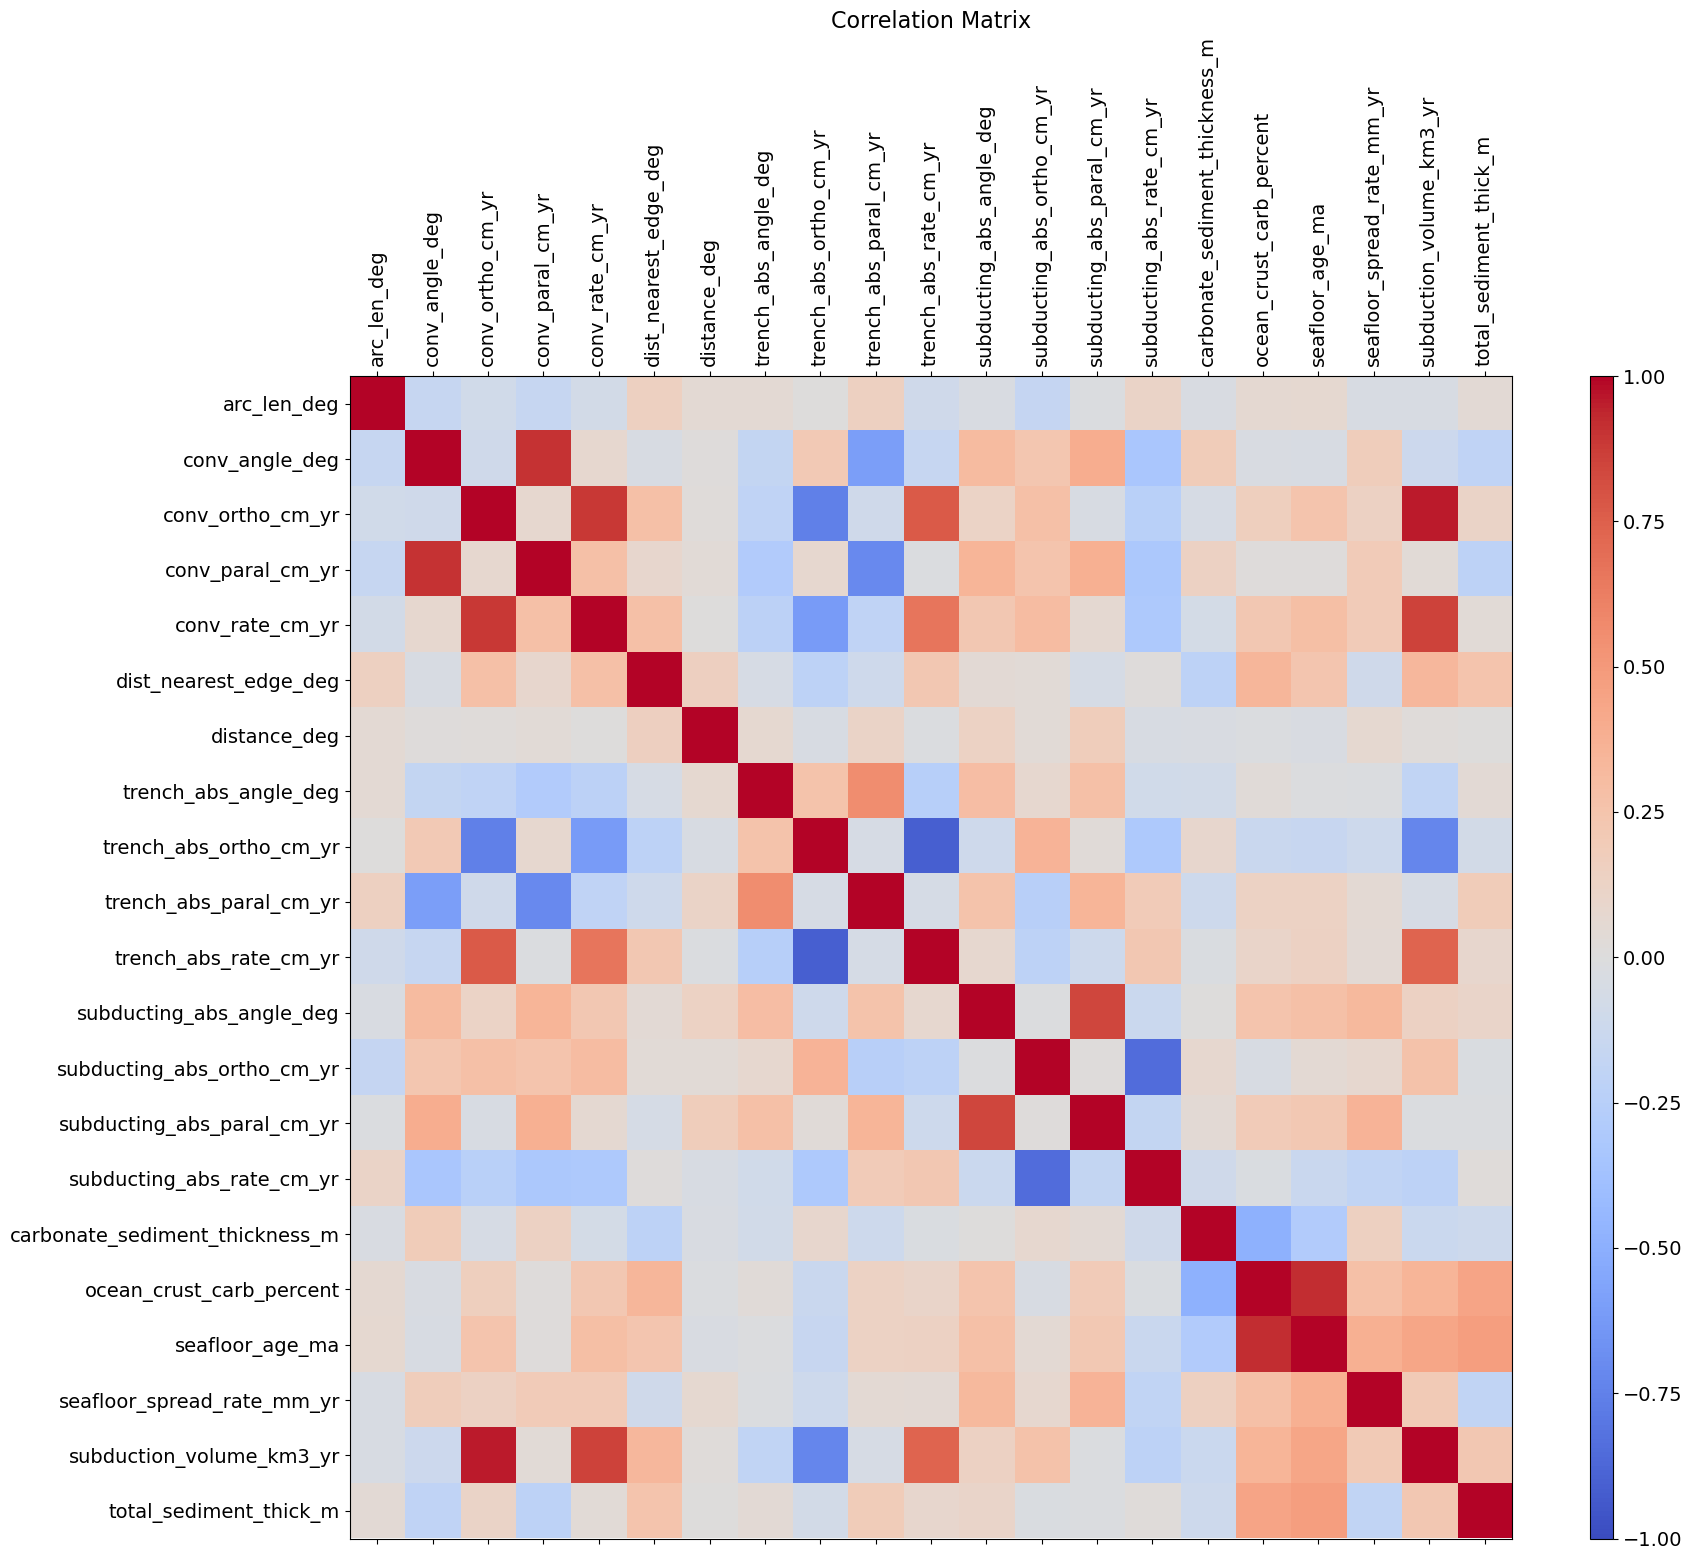

In [20]:
f = plt.figure(figsize=(20, 15))
plt.matshow(corr, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar(aspect=50)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [21]:
for column in corr.columns:
    positive_corr_lst = []
    negative_corr_lst = []
    feature = corr[column]
    for i in range(feature.shape[0]):
        if feature[i] > 0.7:
            positive_corr_lst.append(feature.index[i])
        elif feature[i] < -0.7:
            negative_corr_lst.append(feature.index[i])
    positive_corr_lst.remove(column)
    if positive_corr_lst:
        print(f'{column} is positively correlated with', end=' ')
        print(*positive_corr_lst, sep=', ')
    if negative_corr_lst:
        print(f'{column} is negatively correlated with', end=' ')
        print(*negative_corr_lst, sep=', ')
    if positive_corr_lst or negative_corr_lst:
        print('-----')

conv_angle_deg is positively correlated with conv_paral_cm_yr
-----
conv_ortho_cm_yr is positively correlated with conv_rate_cm_yr, trench_abs_rate_cm_yr, subduction_volume_km3_yr
conv_ortho_cm_yr is negatively correlated with trench_abs_ortho_cm_yr
-----
conv_paral_cm_yr is positively correlated with conv_angle_deg
conv_paral_cm_yr is negatively correlated with trench_abs_paral_cm_yr
-----
conv_rate_cm_yr is positively correlated with conv_ortho_cm_yr, subduction_volume_km3_yr
-----
trench_abs_ortho_cm_yr is negatively correlated with conv_ortho_cm_yr, trench_abs_rate_cm_yr, subduction_volume_km3_yr
-----
trench_abs_paral_cm_yr is negatively correlated with conv_paral_cm_yr
-----
trench_abs_rate_cm_yr is positively correlated with conv_ortho_cm_yr, subduction_volume_km3_yr
trench_abs_rate_cm_yr is negatively correlated with trench_abs_ortho_cm_yr
-----
subducting_abs_angle_deg is positively correlated with subducting_abs_paral_cm_yr
-----
subducting_abs_ortho_cm_yr is negatively corre

# Machine Learning

In [22]:
ml_output_dir = parameters['ml_output_dir']

# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

if os.path.isfile('./model.pkl'):
    print('The model already exists!')
    # load the model
    with open('./model.pkl', 'rb') as f:
        bc_best = pickle.load(f)
    Xy_train_df = pd.read_csv(ml_output_dir + 'Xy_train_muller2019.csv', index_col=False)
else:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    # bc = BaggingPuClassifier(rf, max_samples=int(sum(y_train)), n_jobs=-1, random_state=1)
    bc = BaggingPuClassifier(rf, n_jobs=-1, random_state=42)

    # print('Parameters currently in use:\n')
    # pprint(rf.get_params())

    n_iter = 10
    n_fold = 10
    acc_best = 0
    importances = []

    for i in range(n_iter):
        print(f'Iteration {i+1}')
        smote_gan_file = f'./augmentation/smote_gan_muller2019_{i+1}.csv'
        smote_gan = pd.read_csv(smote_gan_file, index_col=False)
        features = smote_gan[smote_gan.columns[:-1]]
        labels = smote_gan[smote_gan.columns[-1]]
        X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)
        Xy_train = np.hstack((X_train, y_train.values.reshape(-1, 1)))
        Xy_train_df = pd.DataFrame(Xy_train, columns=smote_gan.columns)

        search_space = {
        'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
        'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
        'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
        'base_estimator__min_samples_leaf': Integer(2, 20),
        'base_estimator__min_samples_split': Integer(2, 30),
        'base_estimator__n_estimators': Integer(10, 200),
        'max_samples': Integer(int(0.5*(len(y_train)-sum(y_train))), int(0.9*(len(y_train)-sum(y_train))))
        }

        bc_bayes_search = BayesSearchCV(bc, search_space, n_iter=50, # specify how many iterations
                                        scoring='accuracy', n_jobs=-1, cv=n_fold, verbose=1, random_state=42, return_train_score=True)
        bc_bayes_search.fit(X_train, y_train) # callback=on_step will print score after each iteration

        X_pred = bc_bayes_search.best_estimator_.predict(X_test)
        X_pred_acc = accuracy_score(y_test, X_pred)

        if X_pred_acc > acc_best:
            bc_best = bc_bayes_search.best_estimator_
            bc_best_acc = bc_bayes_search.best_score_
            bc_best_acc_test = X_pred_acc.copy()
            Xy_train_df.to_csv(ml_output_dir + 'Xy_train_muller2019.csv', index=False)
            # pd.DataFrame(bc_bayes_search.cv_results_).to_csv('./hyperparameter_tuning.csv', index=False)
            num_iter = i.copy()

        estimators = bc_bayes_search.best_estimator_.estimators_
        importances.append([estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))])
    
    # save the model
    with open('./model.pkl', 'wb') as f:
        pickle.dump(bc_best, f)
    
    importances_ = []
    for i in range(len(importances)):
        for j in range(n_fold):
            importances_.append(importances[i][j])

    importances = np.hstack(importances_)

The model already exists!


In [23]:
print(bc_best)
# print('\nBest average accuracy:', bc_best_acc)
# print('\nAccuracy (test data): ', bc_best_acc_test)

BaggingPuClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                          max_depth=20,
                                                          max_features='log2',
                                                          min_samples_leaf=2,
                                                          n_estimators=200,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=99, n_jobs=-1, random_state=42)


In [24]:
labels_estimated = []
for pair in bc_best.oob_decision_function_:
    if np.isnan(pair[0]) or pair[0] < pair[1]:
        labels_estimated.append(1)
    else:
        labels_estimated.append(0)
        
print('Number of positive samples', labels_estimated.count(1))
print('Number of negative samples', labels_estimated.count(0))

Number of positive samples 146
Number of negative samples 97


In [25]:
if os.path.isfile('./feature_importances.csv'):
    feature_importances = pd.read_csv('./feature_importances.csv', index_col=False).to_numpy().tolist()
else:
    output_features = Xy_train_original_df.columns.tolist()
    output_features.remove('label')
    output_features_index = [selected_features.index(feature) for feature in output_features]
    selected_features_names = parameters['selected_features_names_nounit']
    selected_features_names = [selected_features_names[i] for i in output_features_index]
    
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(selected_features_names, importances_mean)]
    feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)
    # [print('Feature: {:40} Importance: {}'.format(*pair)) for pair in feature_importances]
    feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    feature_importances_df['Variance'] = importances_var
    feature_importances_df.to_csv('./feature_importances.csv', index=False)

Text(0, 0.5, 'Cumulative Importance')

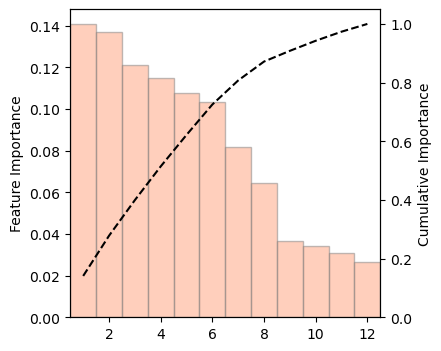

In [26]:
# from scipy.ndimage import gaussian_filter1d

# def smooth_1D(array, std=1):
#     return gaussian_filter1d(array, std)

# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(feature_importances)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(4, 4))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
# ax1.plot(x_values, smooth_1D(cumulative_importances), 'k--')
ax1.plot(x_values, cumulative_importances, 'k--')

# ax1.hlines(y=0.73515, xmin=0, xmax=len(cumulative_importances)+0.5, color='r', linestyles=':')
# plt.text(16, 0.775, '0.75', ha='left', va='center')
# plt.vlines(x=5, ymin=0, ymax=1.05, color='r', linestyles=':')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

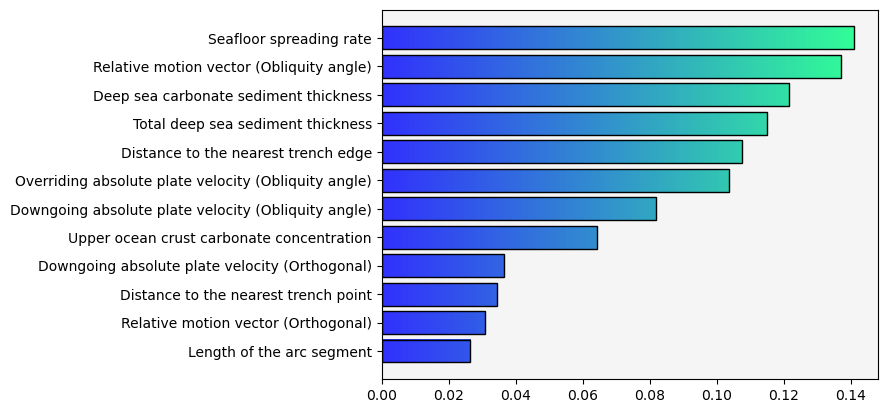

In [27]:
# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in feature_importances]

fig, ax = plt.subplots()
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('winter')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in feature_importances]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
#         # highlight top 5 features
#         for i in range(len(data)-6, len(data)):
#             ax.get_yticklabels()[i].set_color('red')
    ax.axis(lim)

gradientbars(bar, ft_imps)
# plt.grid(linestyle=':')
plt.gca().yaxis.grid(False)
plt.savefig(
    f'./figures/muller2019/importances.png',
    bbox_inches='tight',
    pad_inches=0.1,
    dpi=150
    )
plt.show()

In [28]:
labels_estimated = []
for pair in bc_best.oob_decision_function_:
    if np.isnan(pair[0]):
        labels_estimated.append(2)
    else:
        if pair[0] < pair[1]:
            labels_estimated.append(1)
        else:
            labels_estimated.append(0)

# for i in range(len(labels_estimated)):
#     if labels_estimated[i] == 2 and labels_pul.iloc[i] == 1:
#         labels_estimated[i] = 1

Xy_train_postpul = Xy_train_df.copy()
Xy_train_postpul['label'] = labels_estimated

@interact
def show_map(feature=Xy_train_postpul.columns):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_facecolor('whitesmoke')
    ax2 = ax1.twiny()
    
    # ax1.hist(Xy_train_original_df.loc[Xy_train_original_df['label']==0]['distance_deg'], bins=25, color='none')
    # ax1.hist(Xy_train_original_df.loc[Xy_train_original_df['label']==1]['distance_deg'], bins=25, color='none')
    ax1.hist(Xy_train_original_df[feature], bins=25, alpha=0.0)

    h1 = ax2.hist(Xy_train_postpul.loc[Xy_train_postpul['label']==0][feature], bins=25, color='0.8', label='Negative')
    h2 = ax2.hist(Xy_train_postpul.loc[Xy_train_postpul['label']==2][feature], bins=25, color='LightSalmon', label='Synthetic Positive', alpha=0.8)
    h3 = ax2.hist(Xy_train_postpul.loc[Xy_train_postpul['label']==1][feature], bins=25, color='DarkSeaGreen', label='Positive', alpha=0.4)

    ax2.legend()

    ax2.set_xlabel('Overriding absolute plate velocity (Obliquity angle)' + ' (Standardised)')
    ax1.set_xlabel('Overriding absolute plate velocity (Obliquity angle, deg)')
    
    ax1.set_ylim(0, 40)

interactive(children=(Dropdown(description='feature', options=('arc_len_deg', 'conv_angle_deg', 'conv_ortho_cm…

In [29]:
selected_features_modified = Xy_train_postpul.columns.drop('label')
# push columns by one
selected_features_modified_1 = deque(selected_features_modified)
selected_features_modified_1.rotate()
selected_features_modified_2 = deque(selected_features_modified_1)
selected_features_modified_2.rotate()

@interact
def show_map(feature1=selected_features_modified, feature2=selected_features_modified_1, feature3=selected_features_modified_2):
#     fig = plt.figure(figsize=(16, 12), dpi=150)
#     ax = plt.axes()

    fig = plt.figure()
    gs = GridSpec(2, 2, hspace=0.4, wspace=0.2, height_ratios=[1, 0.03])
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = ax1.twinx()
    ax3 = ax2.twiny()
    
#     fig = plt.figure()
#     ax3 = fig.add_subplot(111)
#     ax2 = ax3.twinx()
#     ax1 = ax2.twiny()
    
    min1 = Xy_train_original_df[feature1].min()
    max1 = Xy_train_original_df[feature1].max()
    min2 = Xy_train_original_df[feature2].min()
    max2 = Xy_train_original_df[feature2].max()

    x_range = np.linspace(min1, max1+0.1*max1, num=100)
    y_range = np.linspace(min2, max2+0.1*max2, num=100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    
    grid_data = griddata(list(zip(Xy_train_original_df[feature1], Xy_train_original_df[feature2])), Xy_train_original_df[feature3],
                         (grid_x, grid_y), method='nearest', fill_value=0)
    grid_data = ndimage.gaussian_filter(grid_data, sigma=3)
    cb1 = ax1.imshow(grid_data.T, extent=(min1, max1, min2, max2), origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)

    sc1 = ax1.scatter(Xy_train_original_df.loc[Xy_train_original_df['label']==0, feature1],
                      Xy_train_original_df.loc[Xy_train_original_df['label']==0, feature2], 40, marker='.', c='blue', alpha=0)
    sc2 = ax1.scatter(Xy_train_original_df.loc[Xy_train_original_df['label']==1, feature1],
                      Xy_train_original_df.loc[Xy_train_original_df['label']==1, feature2], 40, marker='.', c='orange', alpha=0)

    min1 = Xy_train_postpul[feature1].min()
    max1 = Xy_train_postpul[feature1].max()
    min2 = Xy_train_postpul[feature2].min()
    max2 = Xy_train_postpul[feature2].max()
    
    x_range = np.linspace(min1, max1+0.1*max1, num=100)
    y_range = np.linspace(min2, max2+0.1*max2, num=100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    
    grid_data = griddata(list(zip(Xy_train_postpul[feature1], Xy_train_postpul[feature2])), Xy_train_postpul[feature3],
                         (grid_x, grid_y), method='nearest', fill_value=0)
    grid_data = ndimage.gaussian_filter(grid_data, sigma=3)
    cb2 = ax3.imshow(grid_data.T, extent=(min1, max1, min2, max2), origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)
    
    sc3 = ax3.scatter(Xy_train_postpul.loc[Xy_train_postpul['label']==0, feature1],
                      Xy_train_postpul.loc[Xy_train_postpul['label']==0, feature2], 40, marker='.', c='cyan')
    sc4 = ax3.scatter(Xy_train_postpul.loc[Xy_train_postpul['label']==1, feature1],
                      Xy_train_postpul.loc[Xy_train_postpul['label']==1, feature2], 40, marker='.', c='red')
    sc5 = ax3.scatter(Xy_train_postpul.loc[Xy_train_postpul['label']==2, feature1],
                      Xy_train_postpul.loc[Xy_train_postpul['label']==2, feature2], 40, marker='.', c='lime')

    
    ax3.legend([sc3, sc4, sc5], ['Negative', 'Positive', 'Synthetic Positive'], loc='upper right',  borderaxespad=0.1, fontsize=8) # numpoints=1
#     fig.colorbar(cb, shrink=0.5, label=feature3)

    ax1.set_xlabel('Seafloor spreading rate (m)')
    ax1.set_ylabel('Relative motion vector\n(Obliquity angle, deg)')
    ax2.set_ylabel('Relative motion vector\n(Obliquity angle, Standardised)')
    ax3.set_xlabel('Seafloor spreading rate (Standardised)')
    
    cax1 = fig.add_subplot(gs[1, 1])
    cax2 = fig.add_subplot(gs[1, 0])
        
    fig.colorbar(cb2, cax=cax2, orientation='horizontal', label='Overriding absolute plate velocity\n(Obliquity angle, Standardised)', extend='both')
    fig.colorbar(cb1, cax=cax1, orientation='horizontal', label='Overriding absolute plate velocity\n(Obliquity angle, deg)', extend='both')

    plt.show()

interactive(children=(Dropdown(description='feature1', options=('arc_len_deg', 'conv_angle_deg', 'conv_ortho_c…

In [30]:
Xy_train_postpul_pivot = Xy_train_postpul.pivot(columns=['label'])
Xy_train_original_df_pivot = Xy_train_original_df.pivot(columns=['label'])

nb_groups1 = Xy_train_postpul['label'].nunique()
nb_groups2 = Xy_train_original_df['label'].nunique()

@interact
def show_map(feature=Xy_train_postpul.columns):
    bplot1 = [Xy_train_postpul_pivot[feature][var].dropna() for var in Xy_train_postpul_pivot[feature]]
    bplot2 = [Xy_train_original_df_pivot[feature][var].dropna() for var in Xy_train_original_df_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(9, 6))
    box_param = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                     flierprops=dict(marker='.', markeredgecolor='black',
                     fillstyle=None), medianprops=dict(color='black'))

    space = 0.15
    ax1.boxplot(bplot1, positions=np.arange(nb_groups1)-space,
                boxprops=dict(facecolor='tab:blue'), **box_param)

    ax2 = ax1.twinx()
    ax2.boxplot(bplot2, positions=np.arange(nb_groups2)+space,
                boxprops=dict(facecolor='tab:orange'), **box_param)

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
#     ax1.set_xticklabels([f'{label}' for label in np.sort(Xy_train_postpul['label'].unique())])
    ax1.set_xticklabels(['Negative', 'Positive', 'Synthetic Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)

    # format y ticks
    yticks_fmt = dict(axis='y', labelsize=labelsize)
    ax1.tick_params(colors='tab:blue', **yticks_fmt)
    ax2.tick_params(colors='tab:orange', **yticks_fmt)

    # format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', color='tab:blue', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', color='tab:orange', **label_fmt)

    plt.show()

interactive(children=(Dropdown(description='feature', options=('arc_len_deg', 'conv_angle_deg', 'conv_ortho_cm…

In [31]:
Xy_train_postpul_pivot = Xy_train_postpul.pivot(columns=['label'])
Xy_train_original_df_pivot = Xy_train_original_df.pivot(columns=['label'])

nb_groups1 = Xy_train_postpul['label'].nunique()
nb_groups2 = Xy_train_original_df['label'].nunique()

@interact
def show_map(feature=Xy_train_postpul.columns):
    bplot1 = [Xy_train_postpul_pivot[feature][var].dropna() for var in Xy_train_postpul_pivot[feature]]
    bplot2 = [Xy_train_original_df_pivot[feature][var].dropna() for var in Xy_train_original_df_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(5, 5))
    box_param1 = dict(whis=(5, 95), widths=0.2, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='black', fillstyle=None),
                      medianprops=dict(color='black'), boxprops=dict(facecolor='tab:blue'))
    box_param2 = dict(whis=(5, 95), widths=0, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='none', fillstyle=None),
                      medianprops=dict(color='none'), whiskerprops=dict(color='none'),
                      boxprops=dict(facecolor='none', edgecolor='none'))

    ax1.boxplot(bplot1, positions=np.arange(nb_groups1), **box_param1)

    ax2 = ax1.twinx()
    ax2.boxplot(bplot2, positions=np.arange(nb_groups2), **box_param2)

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
#     ax1.set_xticklabels([f'{label}' for label in np.sort(Xy_train_postpul['label'].unique())])
    ax1.set_xticklabels(['Negative', 'Positive', 'Synthetic Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)

    # format y ticks
    yticks_fmt = dict(axis='y', labelsize=labelsize)
#     ax1.tick_params(colors='tab:blue', **yticks_fmt)
#     ax2.tick_params(colors='tab:orange', **yticks_fmt)

    # format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', **label_fmt)

    plt.show()

interactive(children=(Dropdown(description='feature', options=('arc_len_deg', 'conv_angle_deg', 'conv_ortho_cm…

In [32]:
Xy_train_postpul_pivot = Xy_train_postpul.pivot(columns=['label'])
Xy_train_original_df_pivot = Xy_train_original_df.pivot(columns=['label'])

nb_groups1 = Xy_train_postpul['label'].nunique()
nb_groups2 = Xy_train_original_df['label'].nunique()

@interact
def show_map(feature=Xy_train_postpul.columns):
    vplot1 = [Xy_train_postpul_pivot[feature][var].dropna() for var in Xy_train_postpul_pivot[feature]]
    vplot2 = [Xy_train_original_df_pivot[feature][var].dropna() for var in Xy_train_original_df_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(5, 5))
#     box_param1 = dict(whis=(5, 95), widths=0.2, patch_artist=True,
#                       flierprops=dict(marker='.', markeredgecolor='black', fillstyle=None),
#                       medianprops=dict(color='black'), boxprops=dict(facecolor='tab:blue'))
    # violin_param2 = dict(bodies=dict(facecolor='none', edgecolor='none'))

    vplot1_parts = ax1.violinplot(vplot1, positions=np.arange(nb_groups1))
    
    ax2 = ax1.twinx()
    vplot2_parts = ax2.violinplot(vplot2, positions=np.arange(nb_groups2))
    
    # ['bodies', 'cmeans', 'cmins', 'cmaxes', 'cbars', 'cmedians', 'cquantiles']
    for part in vplot2_parts['bodies']:
        part.set_facecolor('none')
        part.set_edgecolor('none')
        
    vplot2_parts['cbars'].set_edgecolor('none')
    vplot2_parts['cmins'].set_edgecolor('none')
    vplot2_parts['cmaxes'].set_edgecolor('none')

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
#     ax1.set_xticklabels([f'{label}' for label in np.sort(Xy_train_postpul['label'].unique())])
    ax1.set_xticklabels(['Negative', 'Positive', 'Synthetic Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)

    # format y ticks
    yticks_fmt = dict(axis='y', labelsize=labelsize)
#     ax1.tick_params(colors='tab:blue', **yticks_fmt)
#     ax2.tick_params(colors='tab:orange', **yticks_fmt)

    # format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', **label_fmt)
    
    plt.show()

interactive(children=(Dropdown(description='feature', options=('arc_len_deg', 'conv_angle_deg', 'conv_ortho_cm…

### Probability

In [33]:
target_points_prob_files_lst = []
target_points_prob_lst = []

for time in time_steps:
    target_points_prob_files_lst.append(ml_output_dir + f'target_points_prob_{time}_Ma.csv')

for i, target_points_prob_file in tqdm(enumerate(target_points_prob_files_lst), total=len(target_points_prob_files_lst)):
# for target_points_prob_file in target_points_prob_files_lst:
    if not(os.path.isfile(target_points_prob_file)):
        df = target_points_ml_in_lst[target_points_prob_files_lst.index(target_points_prob_file)]
        probs = bc_best.predict_proba(df)[:, 1].reshape(-1, 1)

        mm_scaler1 = MinMaxScaler()
        probs_scaled = mm_scaler1.fit_transform(probs)

        df_xy = df.copy()
        df_xy['lon'] = target_points_coreg_out_lst[i]['lon'].to_numpy()
        df_xy['lat'] = target_points_coreg_out_lst[i]['lat'].to_numpy()
        df_xy['prob'] = probs_scaled
        df_xy.to_csv(target_points_prob_file, index=False)
        target_points_prob_lst.append(df_xy)
        
for target_points_prob_file in target_points_prob_files_lst:
    target_points_prob_lst.append(pd.read_csv(target_points_prob_file, index_col=False))

  0%|          | 0/51 [00:00<?, ?it/s]

In [34]:
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps):
    lons_lats_recon = []
    
    for min_occ in min_occ_data.iterrows():
        if time == 0:
            lons_lats_recon.append((min_occ[1]['lon'], min_occ[1]['lat']))
        elif int(min_occ[1]['age']) < time:
            lons_lats_recon.append((np.nan, np.nan))
        elif int(min_occ[1]['age']) == time:
            lons_lats_recon.append((min_occ[1]['lon_recon'], min_occ[1]['lat_recon']))
        else:
            lat_lon_recon = get_recon_ccords([min_occ[1]['lon']],
                                             [min_occ[1]['lat']],
                                             plate_motion_model='muller2019',
                                             time=time)[0]
            lons_lats_recon.append(tuple((lat_lon_recon[1], lat_lon_recon[0])))
            
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    plot_x = target_points_prob_lst[time_steps.index(time)]['lon']
    plot_y = target_points_prob_lst[time_steps.index(time)]['lat']
    
    # dual colour bars
    fig = plt.figure(figsize=(6, 8))
    gs = GridSpec(2, 2, hspace=-0.1, wspace=0.1, height_ratios=[1, 0.02])
    ax = fig.add_subplot(gs[0, :], projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=9)

    im = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    sc0 = ax.scatter(
        plot_x,
        plot_y,
        transform=ccrs.PlateCarree(),
        marker='.',
        c=target_points_prob_lst[time_steps.index(time)]['prob'],
        s=30,
        cmap='Spectral_r',
        zorder=5
    )
    
    sc1 = ax.scatter(
        [coords[0] for coords in lons_lats_recon],
        [coords[1] for coords in lons_lats_recon],
        transform=ccrs.PlateCarree(),
        marker='.',
        c='black',
        s=10,
        zorder=6
    )

    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=7)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=8)

    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    fig.colorbar(sc0, cax=cax2, orientation='horizontal', label='Probability')
    fig.colorbar(im, cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [35]:
mask_coords_lst = []
for mask_coords_file in mask_coords_files_lst:
    mask_coords_lst.append(pd.read_csv(mask_coords_file, index_col=False))

proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(time=time_steps):
    lons_lats_recon = []
    
    for min_occ in min_occ_data.iterrows():
        if time == 0:
            lons_lats_recon.append((min_occ[1]['lon'], min_occ[1]['lat']))
        elif int(min_occ[1]['age']) < time:
            lons_lats_recon.append((np.nan, np.nan))
        elif int(min_occ[1]['age']) == time:
            lons_lats_recon.append((min_occ[1]['lon_recon'], min_occ[1]['lat_recon']))
        else:
            lat_lon_recon = get_recon_ccords(min_occ[1]['lon'],
                                             min_occ[1]['lat'],
                                             plate_motion_model='muller2019',
                                             time=time)[0]
            lons_lats_recon.append(tuple((lat_lon_recon[1], lat_lon_recon[0])))

    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    mask_coords = mask_coords_lst[time_steps.index(time)]
    
    probabilities = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            probabilities.append(target_points_prob_lst[time_steps.index(time)]['prob'][count])
            count += 1
        else:
            probabilities.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    probabilities_2d = np.reshape(probabilities, (ny, nx))
    probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))
    
    # dual colour bars
    fig = plt.figure(figsize=(6, 8))
    gs = GridSpec(2, 2, hspace=-0.1, wspace=0.1, height_ratios=[1, 0.02])
    ax = fig.add_subplot(gs[0, :], projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=9)

    im0 = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)

    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    im1 = plt.imshow(
        probabilities_2d,
        transform=ccrs.PlateCarree(),
        origin='lower',
        cmap='Spectral_r',
        interpolation='gaussian',
        extent=(x_min, x_max, y_min, y_max),
        zorder=5
    )
    
    sc1 = ax.scatter(
        [coords[0] for coords in lons_lats_recon],
        [coords[1] for coords in lons_lats_recon],
        transform=ccrs.PlateCarree(),
        marker='.',
        c='black',
        s=10,
        zorder=6
    )

    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=7)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=8)
    
    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    fig.colorbar(im1, cax=cax2, orientation='horizontal', label='Probability')
    fig.colorbar(im0, cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')
        
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [36]:
min_occ_prob_dir = parameters['min_occ_prob_dir']
min_occ_prob_files_lst = []
min_occ_prob_tran_files_lst = []

for index in min_occ_data['index']:
    min_occ_prob_files_lst.append(min_occ_prob_dir + f'min_occ_features_{index}.csv')
    min_occ_prob_tran_files_lst.append(min_occ_prob_dir + f'min_occ_features_tran_{index}.csv')

# coregistration_point(
#     min_occ_data,
#     conv_dir,
#     conv_prefix,
#     conv_ext,
#     min_occ_prob_dir,
#     file_prefix='min_occ_features',
#     time_steps=time_steps,
#     search_radius=4,
#     plate_motion_model='muller2019'
# )

# for min_occ_prob_file, min_occ_prob_tran_file in zip(min_occ_prob_files_lst, min_occ_prob_tran_files_lst):
#     min_occ_prob = pd.read_csv(min_occ_prob_file, index_col=False)
#     min_occ_prob_tran = min_occ_prob.copy()
#     probs = []
    
#     for i, row in min_occ_prob.iterrows():
#         try:
#             row_features = row[features_list]
#         except:
#             Xy_train_original_df = pd.read_csv(ml_input_dir + 'features_labels_original.csv', index_col=False)
#             features_list = Xy_train_original_df.columns.to_list()
#             features_list.remove('label')
#             row_features = row[features_list]
            
#         if row_features.isnull().values.any():
#             probs.append(np.nan)
#         else:
#             try:
#                 row_features = st_scaler.transform(row_features.values.reshape(1, -1))
#             except:
#                 # load the model
#                 with open('./st_scaler.pkl', 'rb') as f:
#                     st_scaler = pickle.load(f)
#                 row_features = st_scaler.transform(row_features.values.reshape(1, -1))

#             # min_occ_prob_tran.iloc[i][features_list] = row_features[0].tolist()
#             min_occ_prob_tran.loc[min_occ_prob_tran['age'] == i, features_list] = row_features[0].tolist()
#             prob = bc_best.predict_proba(row_features)[0, 1]
#             probs.append(prob)
    
#     mm_scaler2 = MinMaxScaler()
#     probs_scaled = mm_scaler2.fit_transform(np.array(probs).reshape(-1, 1))
#     min_occ_prob['prob'] = probs_scaled
#     min_occ_prob_tran['prob'] = probs_scaled
#     min_occ_prob.to_csv(min_occ_prob_file, index=False)
#     min_occ_prob_tran.to_csv(min_occ_prob_tran_file, index=False)

In [37]:
# Total Tonnage: Frieda River with 2777 Mt (141.73, -4.66) index: 14, age: 14
# Au Grade: Tolukuma with 29.9 ppm (147.13, -8.56) index: 9, age: 5
# Au Tonnage: Ladolam (lihir) with 63.6 Moz (152.63, -3.13) index: 3, age: 1
# Cu Grade: Solwara 1 with 7.7 % (152.1, -3.79) index:29, age: 0
# Cu Tonnage: Frieda River with 13.1 Mt (141.73, -4.66) index: 14, age: 14

Xy_train_original_df = pd.read_csv(ml_input_dir + 'features_labels_original.csv', index_col=False)
features_list = Xy_train_original_df.columns.to_list()
features_list.remove('label')

from scipy.ndimage import gaussian_filter1d

def smooth_1D(array, std=2):
    return gaussian_filter1d(array, std)

@interact
def show_map(file1=min_occ_prob_files_lst, file2=min_occ_prob_tran_files_lst, feature=features_list):
    df1 = pd.read_csv(file1, index_col=False)
    df2 = pd.read_csv(file2, index_col=False)

    fig = plt.figure(figsize=(12, 4))
    ax2 = fig.add_subplot(121, xlim=[df1['age'].max(), 0])
    ax1 = ax2.twinx()

    ax2.plot(df1['age'], df1['prob'], c='red')
    # ax2.plot(df1['age'], smooth_1D(df1['prob']), c='red')
    
    index1 = min_occ_prob_files_lst.index(file1)
    age1 = min_occ_data.iloc[index1]['age']
    ax2.vlines(x=age1, ymin=0, ymax=1, color='k', linestyles=':')
    
    ax2.set_ylim(0, 1)
    ax1.plot(df1['age'], df1[feature], c='blue')
    # ax1.plot(df['age'], smooth_1D(df[feature]), c='blue')
    
    ax4 = fig.add_subplot(122, xlim=[df2['age'].max(), 0])
    ax3 = ax4.twinx()

    ax4.plot(df2['age'], df2['prob'], c='red')
    
    index2 = min_occ_prob_tran_files_lst.index(file2)
    age2 = min_occ_data.iloc[index2]['age']
    ax4.vlines(x=age2, ymin=0, ymax=1, color='k', linestyles=':')
    
    ax4.set_ylim(0, 1)
    ax3.plot(df2['age'], df2[feature], c='blue')

    ax2.set_ylabel('Probability')
    ax1.set_ylabel(feature + ' (Actual)')
    ax4.set_ylabel('Probability')
    ax3.set_ylabel(feature + ' (Standardised)')
    
    fig.tight_layout()
    
    plt.show()

interactive(children=(Dropdown(description='file1', options=('./min_occ_prob_muller2019/min_occ_features_0.csv…

In [69]:
# Total Tonnage: Frieda River with 2777 Mt (141.73, -4.66) index: 14, age: 14
# Au Grade: Tolukuma with 29.9 ppm (147.13, -8.56) index: 9, age: 5
# Au Tonnage: Ladolam (lihir) with 63.6 Moz (152.63, -3.13) index: 3, age: 1
# Cu Grade: Solwara 1 with 7.7 % (152.1, -3.79) index:29, age: 0
# Cu Tonnage: Frieda River with 13.1 Mt (141.73, -4.66) index: 14, age: 14

Xy_train_original_df = pd.read_csv(ml_input_dir + 'features_labels_original.csv', index_col=False)
features_list = Xy_train_original_df.columns.to_list()
features_list.remove('label')

from scipy.ndimage import gaussian_filter1d

def smooth_1D(array, std=2):
    return gaussian_filter1d(array, std)

@interact
def show_map(file1=min_occ_prob_files_lst, feature=features_list):
    df1 = pd.read_csv(file1, index_col=False)

    fig = plt.figure(figsize=(6, 4))
    ax2 = fig.add_subplot(111, xlim=[df1['age'].max(), 0])
    ax1 = ax2.twinx()

    ax2.plot(df1['age'], df1['prob'], c='darkorange')
    # ax2.plot(df1['age'], smooth_1D(df1['prob']), c='red')
    
#     index1 = min_occ_prob_files_lst.index(file1)
#     age1 = min_occ_data.iloc[index1]['age']
#     ax2.vlines(x=age1, ymin=0, ymax=1, color='k', linestyles=':')
    
    ax2.set_ylim(0, 1)
    ax1.plot(df1['age'], df1[feature], c='royalblue')
    # ax1.plot(df['age'], smooth_1D(df[feature]), c='blue')
    
    ax2.set_xlabel('Age (Ma)')
    ax2.set_ylabel('Mineralisation probability')
    ax1.set_ylabel('Overriding absolute plate velocity\n(Obliquity angle, deg)')
    
    fig.tight_layout()
    
    plt.show()

interactive(children=(Dropdown(description='file1', options=('./min_occ_prob_muller2019/min_occ_features_0.csv…

In [38]:
proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(file=min_occ_prob_files_lst, time=time_steps):
    df = pd.read_csv(file, index_col=False)
    lons = df.loc[df['age'] >= time]['lon'].tolist()
    lats = df.loc[df['age'] >= time]['lat'].tolist()
    bm = df.loc[df['age'] >= time]['before_mineralisation'].tolist()
    val = df.loc[df['age'] >= time]['valid'].tolist()
    
    lons_inval = []
    lats_inval = []
    lons_bm = []
    lats_bm = []
    lons_am = []
    lats_am = []
    
    # colour of the last point
    if not val[0]:
        last_point = 'invalid'
    elif bm[0]:
        last_point = 'before_mineralisation'
    else:
        last_point = 'after_mineralisation'
    
    for index in range(1, len(lons)):
        if not val[index]:
            lons_inval.append(lons[index])
            lats_inval.append(lats[index])
        elif bm[index]:
            lons_bm.append(lons[index])
            lats_bm.append(lats[index])
        else:
            lons_am.append(lons[index])
            lats_am.append(lats[index])
        
    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    mask_coords = mask_coords_lst[time_steps.index(time)]
    
    probabilities = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            probabilities.append(target_points_prob_lst[time_steps.index(time)]['prob'][count])
            count += 1
        else:
            probabilities.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    probabilities_2d = np.reshape(probabilities, (ny, nx))
    probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))
    
    # single colour bar
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=10)

    im0 = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)
    
    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    im1 = plt.imshow(
        probabilities_2d,
        transform=ccrs.PlateCarree(),
        origin='lower',
        cmap='Spectral_r',
        interpolation='gaussian',
        extent=(x_min, x_max, y_min, y_max),
        alpha=0.5,
        zorder=5
    )
    
    if last_point == 'invalid':
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='gray', s=20, zorder=6)
    elif last_point == 'before_mineralisation':
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='black', s=20, zorder=6)
    else:
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='red', s=20, zorder=6)
    
    sc = ax.scatter(lons_bm, lats_bm, transform=ccrs.PlateCarree(), marker='.', facecolor='black', s=20, zorder=7)
    sc = ax.scatter(lons_am, lats_am, transform=ccrs.PlateCarree(), marker='.', facecolor='red', s=20, zorder=7)
    sc = ax.scatter(lons_inval, lats_inval, transform=ccrs.PlateCarree(), marker='.', facecolor='gray', s=20, zorder=7)
    
    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=8)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=9)
    
    fig.colorbar(im1, orientation='horizontal', shrink=0.4, pad=0.05, label='Probability')
    
    plt.show()

interactive(children=(Dropdown(description='file', options=('./min_occ_prob_muller2019/min_occ_features_0.csv'…

In [39]:
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe

def make_lines_glow(
    ax=None,
    n_glow_lines: int = 10,
    diff_linewidth: float = 1.05,
    alpha_line: float = 0.3,
    lines=None,
) -> None:
    """Add a glow effect to the lines in an axis object.
    Each existing line is redrawn several times with increasing width and low alpha to create the glow effect.
    """
    if not ax:
        ax = plt.gca()

    lines = ax.get_lines() if lines is None else lines
    lines = [lines] if isinstance(lines, Line2D) else lines

    alpha_value = alpha_line / n_glow_lines

    for line in lines:

        data = line.get_data(orig=False)
        linewidth = line.get_linewidth()
        
        try:
            step_type = line.get_drawstyle().split('-')[1]
        except:
            step_type = None

        for n in range(1, n_glow_lines + 1):
            if step_type:
                glow_line, = ax.step(*data)
            else:
                glow_line, = ax.plot(*data)
            glow_line.update_from(line)  # line properties are copied as seen in this solution: https://stackoverflow.com/a/54688412/3240855

            glow_line.set_alpha(alpha_value)
            glow_line.set_linewidth(linewidth + (diff_linewidth * n))
            glow_line.is_glow_line = True  # mark the glow lines, to disregard them in the underglow function.


proj = ccrs.LambertAzimuthalEqualArea(150, 0)

@interact
def show_map(file=min_occ_prob_files_lst, time=time_steps):
    df = pd.read_csv(file, index_col=False)
    lons = df.loc[df['age'] >= time]['lon'].tolist()
    lats = df.loc[df['age'] >= time]['lat'].tolist()
    bm = df.loc[df['age'] >= time]['before_mineralisation'].tolist()
    val = df.loc[df['age'] >= time]['valid'].tolist()
        
    # colour of the last point
    if not val[0]:
        last_point = 'invalid'
    elif bm[0]:
        last_point = 'before_mineralisation'
    else:
        last_point = 'after_mineralisation'

    # list of invalid lines
    lons_inval = []
    lats_inval = []
    lons_inval_temp = []
    lats_inval_temp = []

    for index2 in range(len(lons)-1, -1, -1):
        if not val[index2]:
            lons_inval_temp.append(lons[index2])
            lats_inval_temp.append(lats[index2])
            if index2 == 0:
                lons_inval.append(lons_inval_temp)
                lats_inval.append(lats_inval_temp)
        else:
            if len(lons_inval_temp) != 0:
                lons_inval_temp.append(lons[index2])
                lats_inval_temp.append(lats[index2])
                lons_inval.append(lons_inval_temp)
                lats_inval.append(lats_inval_temp)
                lons_inval_temp = []
                lats_inval_temp = []
            else:
                continue

    # list of lines created before mineralisation
    lons_bm = []
    lats_bm = []
    lons_bm_temp = []
    lats_bm_temp = []

    for index2 in range(len(lons)-1, -1, -1):
        if bm[index2] and val[index2]:
            lons_bm_temp.append(lons[index2])
            lats_bm_temp.append(lats[index2])
            if index2 == 0:
                lons_bm.append(lons_bm_temp)
                lats_bm.append(lats_bm_temp)
        else:
            if len(lons_bm_temp) != 0:
                lons_bm_temp.append(lons[index2])
                lats_bm_temp.append(lats[index2])
                lons_bm.append(lons_bm_temp)
                lats_bm.append(lats_bm_temp)
                lons_bm_temp = []
                lats_bm_temp = []
            else:
                continue

    # list of lines created after mineralisation
    lons_am = []
    lats_am = []
    lons_am_temp = []
    lats_am_temp = []

    for index2 in range(len(lons)-1, -1, -1):
        if not bm[index2] and val[index2]:
            lons_am_temp.append(lons[index2])
            lats_am_temp.append(lats[index2])
            if index2 == 0:
                lons_am.append(lons_am_temp)
                lats_am.append(lats_am_temp)
        else:
            if len(lons_am_temp) != 0:
                lons_am_temp.append(lons[index2])
                lats_am_temp.append(lats[index2])
                lons_am.append(lons_am_temp)
                lats_am.append(lats_am_temp)
                lons_am_temp = []
                lats_am_temp = []
            else:
                continue

    # call the PlotTopologies object
    gplot = gplately.PlotTopologies(model, coastlines, continents, cob, time=time)
    agegrid_file = agegrid_dir + f'Muller_etal_2019_Tectonics_v2.0_AgeGrid-{time}.nc'
    agegrid = gplately.grids.read_netcdf_grid(agegrid_file)
    
    mask_coords = mask_coords_lst[time_steps.index(time)]
    
    probabilities = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            probabilities.append(target_points_prob_lst[time_steps.index(time)]['prob'][count])
            count += 1
        else:
            probabilities.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    probabilities_2d = np.reshape(probabilities, (ny, nx))
    probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))
    
    # single colour bar
    fig = plt.figure(figsize=(6, 8))
    ax = plt.axes(projection=proj)
    
    set_ax(ax, target_extent, 15, 15, stock_img=False, order=10)

    im0 = gplot.plot_grid(ax, agegrid.data, cmap='Blues', vmin=0, vmax=230, alpha=0.7, zorder=1)
    
    gplot.plot_continents(ax, edgecolor='none', facecolor='tan', zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='red', alpha=0.5, zorder=3)
    gplot.plot_plate_motion_vectors(ax, spacingX=20, spacingY=20, normalise=False, regrid_shape=20, alpha=0.2, zorder=4)
    
    im1 = plt.imshow(
        probabilities_2d,
        transform=ccrs.PlateCarree(),
        origin='lower',
        cmap='Spectral_r',
        interpolation='gaussian',
        extent=(x_min, x_max, y_min, y_max),
        alpha=0.5,
        zorder=5
    )
        
    for lons_, lats_ in zip(lons_bm, lats_bm):
        sc = ax.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='black', zorder=6)
#         sc = ax.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='black', path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()], zorder=6)
#         sc = ax.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='black', path_effects=[pe.SimpleLineShadow(shadow_color='g'), pe.Normal()], zorder=6)
        
    for lons_, lats_ in zip(lons_am, lats_am):
        sc = ax.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='red', zorder=6)
        
    for lons_, lats_ in zip(lons_inval, lats_inval):
        sc = ax.plot(lons_, lats_, transform=ccrs.PlateCarree(), color='gray', zorder=6)
        
    if last_point == 'invalid':
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='gray', s=20, zorder=7)
    elif last_point == 'before_mineralisation':
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='black', s=20, zorder=7)
    else:
        sc = ax.scatter(lons[0], lats[0], transform=ccrs.PlateCarree(), marker='*', facecolor='red', s=20, zorder=7)
    
    gplot.plot_trenches(ax, color='k', alpha=0.3, zorder=8)
    gplot.plot_subduction_teeth(ax, spacing=0.03, color='k', alpha=0.3, zorder=9)
    
    fig.colorbar(im1, orientation='horizontal', shrink=0.4, pad=0.05, label='Probability')
    
#     make_lines_glow()
    
    plt.show()

interactive(children=(Dropdown(description='file', options=('./min_occ_prob_muller2019/min_occ_features_0.csv'…